In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1)

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
  mean_absolute_error,
  mean_squared_error,
  mean_absolute_percentage_error,
  accuracy_score,
  f1_score
)

from sklearn.utils import resample

import random

In [2]:
n_classes = 10

X, y = load_digits(n_class=n_classes, return_X_y=True)
to_sample = False

In [3]:
# X, y = sampled[:, :-1], np.array(sampled[:, -1], dtype=np.int32)
X.shape, y.shape, np.unique(y)

((1797, 64), (1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

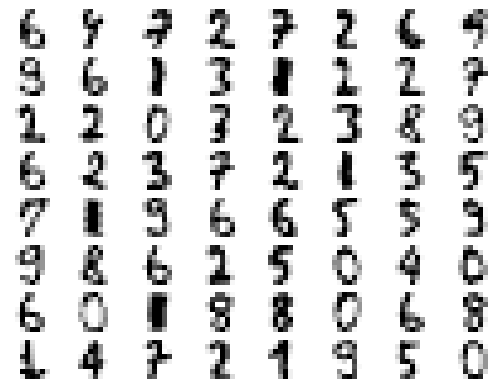

In [4]:
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(X[random.randint(0, X.shape[0])].reshape(8, 8), cmap='Greys')

In [5]:
X.shape, y.shape

((1797, 64), (1797,))

In [6]:
n_features = X.shape[1]
n_targets = n_classes

In [7]:
%load_ext autoreload
%autoreload

In [8]:
from common.distributor import UniformDataDistributor, DataDistributor
from optimization.federative.fedavg import FederatedAveraging, Model
from optimization.federative.scaffold import Scaffold
from optimization.federative.fedprox import FedProx
from optimization.federative.scaffnew import Scaffnew
from optimization.federative.fedfair import FedFair

/Users/locllos/anaconda3/envs/DS-3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-11 18:20:17,655	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [9]:
from function.vanilla import MSERidgeLinear, MSELassoLinear
from function.torch import TorchFunction

In [10]:
import torch

In [11]:
torch_model = torch.nn.Sequential(
  torch.nn.Linear(n_features, 32),
  torch.nn.Sigmoid(),
  torch.nn.Linear(32, n_targets),
  torch.nn.Softmax(dim=-1)
)
function = TorchFunction(torch_model, torch.nn.CrossEntropyLoss())

torch_enable = True

In [12]:
sum([params.numel() for params in torch_model.parameters()])

2410

In [12]:
distributor = DataDistributor(test_size=0.2, server_fraction=0.2)

In [13]:
from pipeline.pipeline import Pipeline

In [27]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



Scaffold for parameters: {'n_clients': 32, 'iid_fraction': 0.3, 'clients_fraction': 0.4, 'batch_size': 256, 'epochs': 256, 'rounds': 48, 'eta': 0.75}:


learning: 100%|██████████| 48/48 [00:09<00:00,  4.88it/s]


f1_score : 0.9576923076923077

FedFair for parameters: {'n_clients': 32, 'iid_fraction': 0.3, 'clients_fraction': 0.4, 'batch_size': 256, 'epochs': 256, 'rounds': 48, 'eta': 0.75, 'lmbd': 0.01}:


learning: 100%|██████████| 48/48 [00:09<00:00,  4.83it/s]


f1_score : 0.9719276094276093

Scaffnew for parameters: {'n_clients': 32, 'iid_fraction': 0.3, 'clients_fraction': 1, 'batch_size': 256, 'rounds': 48, 'eta': 0.75, 'proba': 0.001953125}:


learning: 100%|██████████| 48/48 [00:22<00:00,  2.17it/s]


f1_score : 0.9861111111111112
done


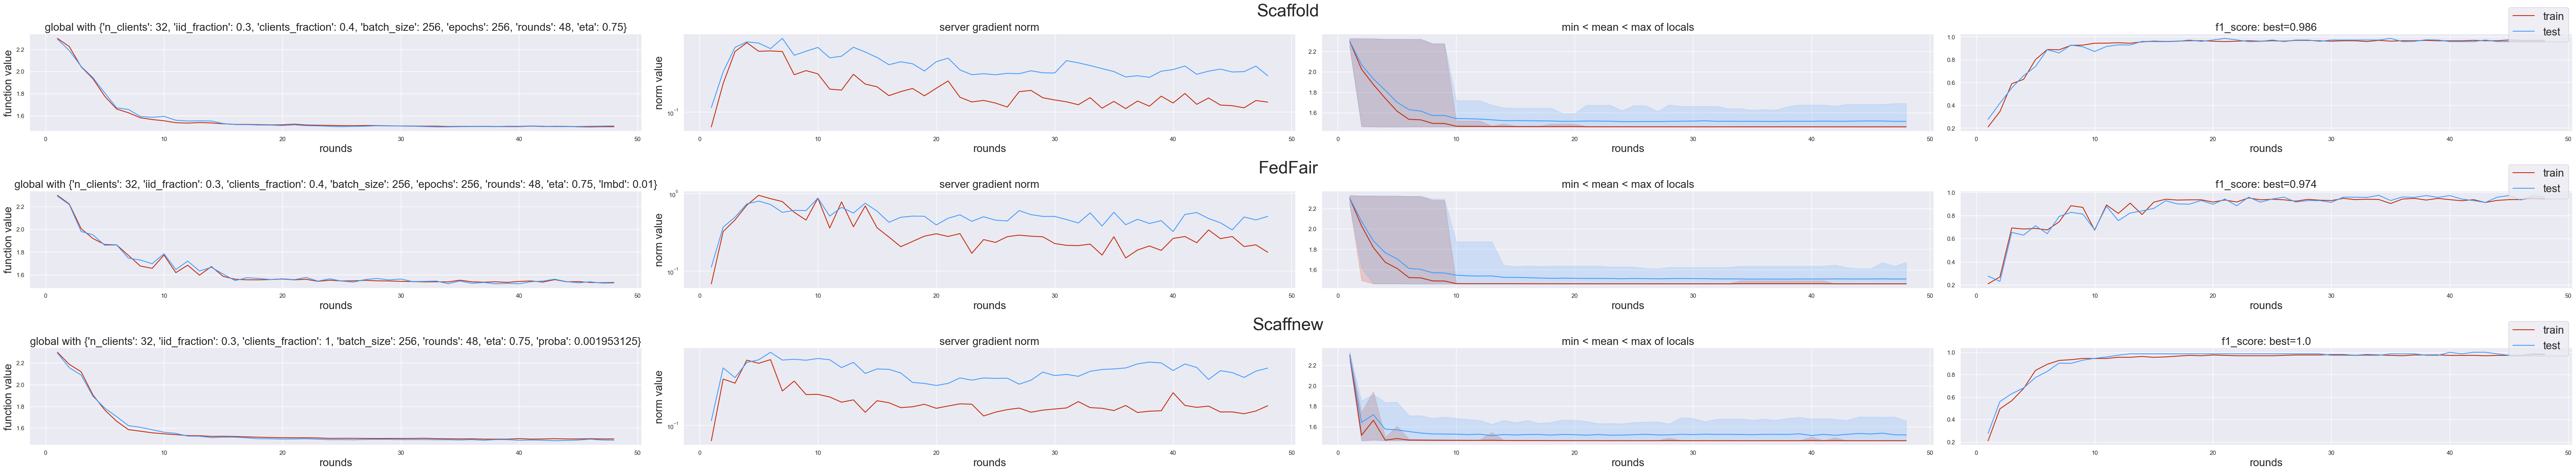

In [31]:
optimizer_parameters = {
  Scaffold : {
    "n_clients" : [32],
    "iid_fraction" : [0.3],
    "clients_fraction": [0.4],
    "batch_size": [256], 
    "epochs": [256], # 16, 64, 
    "rounds": [48],
    "eta": [75e-2], # , 1e-2
  },
  FedFair : {
    "n_clients" : [32],
    "iid_fraction" : [0.3],
    "clients_fraction": [0.4],
    "batch_size": [256], 
    "epochs": [256], # 16, 64, 
    "rounds": [48],
    "eta": [75e-2], # , 1e-2
    "lmbd" : [1e-2]
  },
  Scaffnew : {
    "n_clients" : [32],
    "iid_fraction" : [0.3],
    "clients_fraction": [1], # funny things happens when clients_fraction is not 1
    "batch_size": [256], 
    "rounds": [48],
    "eta": [75e-2], # , 1e-2
    "proba" : [1/512]
  }
}

metrics = {
  "f1_score" : lambda y_proba, y_true: f1_score(np.argmax(y_proba, axis=1), y_true, average="weighted")
}

pipeline = Pipeline(
  function=function,
  metrics=metrics,
  optimizer_parameters=optimizer_parameters,
  distributor=distributor,
  X=X,
  y=y,
)

best, best_params = pipeline.run(
  choose_best_by="accuracy",
  scaled=False,
  with_grads=True,
  reducers=[]
)

print("done")

In [113]:
best_params

{'clients_fraction': 0.3, 'batch_size': 64, 'epochs': 128, 'eta': 0.001}